# **Energy Spectrum of a Fluxonium**
*by Pelin Yıldırım <br> QWorld Summer Research Internship <br> QIntern 2020*

This notebook is aimed to analyze physical properties of fluxonium circuit, which is composed of a Josephson junction shunt by an array of Josephson junctions and driven by an external flux. Array of Josephson junctions is represented by an inductor and the circuit schematics is shown below:  <br> 
![Fluxonium Circuit Schematics](https://qytbla.dm.files.1drv.com/y4mxrlSSPcpqehdZvrfacZCgCEzza2EPVNg7JTzzygJUfmsYJxJE9YjLnkIcKJCSWziOzhlxHEqfqWocX77sjXwaSEiVunYgr-ejsQkz6z_JEDOCiLmdx8SUGms3NUOocoK4Aa4bIY-4w4w31v4gX8kUTglaeFxMsVyr8g-GIBph3c15Bi0RF_sC5hC2zODRTnZ_cT2ATO4EpHvqfG48AEXgA?width=369&height=293&cropmode=none) 


## Introduction
By using the Python code written below, we are going to create the Hamiltonian of the circuit first, and then draw the relevant graphs of the circuit. <br> Most of the code below is written by someone else and is available at [GitHub](https://github.com/SchusterLab/slab/blob/master/circuitqed.py). 

### Why Fluxonium? 
Fluxonium circuits are charge insensitive in contrast with CPB circuits and also their coherence values are better than CPB. [1] 

### Necessary Python Libraries 
The code below is to add Pyhton libraries to be used through the code. 

In [ ]:
!pip install --upgrade qutip 
import qutip
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import numpy as np

from scipy import sparse
from scipy.sparse.linalg import eigsh
from numpy import pi, linspace, cos, sin, ones, transpose, reshape, array, argsort, sort, \
    meshgrid, amax, amin, dot, sqrt, exp, tanh, sign, argmax
from numpy.linalg import eig
from scipy.constants import hbar, m_e, elementary_charge as q_e

     |████████████████████████████████| 3.4MB 4.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for qutip: filename=qutip-4.5.2-cp36-cp36m-linux_x86_64.whl size=12575471 sha256=bd7dc1449adc46c214f9d224a5e74aa5bb05cecf6f8df4be7a5b66bc53843f05
  Stored in directory: /root/.cache/pip/wheels/ae/90/e9/f26fdecfb6c0e9d9d6f5fa564d16d26ff2bdfd8ad6e7a8a28a
Successfully built qutip


## Hamiltonian of Fluxonium Circuit

### Mathematical Representation 
The hamiltonian of the circuit given in the figure is as follows: [2] 
$$ H=4E_cn^2+\frac{1}{2}E_L\phi^2-E_jcos(\phi-\phi_{ext}) $$
where $n=q/2e$ is junction capacitor charge (in units of Cooper pairs), $\phi$ is phase twist across the inductance, $\phi_{ext}=\Phi_{ext}/\Phi_0$ is the reduced external flux, $\Phi_{ext}$ is the applied external flux, $\Phi_0=h/2e$ is the flux quantum, $E_L=(\hbar/2e)^2/L_A$ is the inductive energy, $E_c=e^2/2C_j$ is the charging energy, $E_j=(\hbar/2e)^2/L_j$ is the Josepson energy. [3]

### Python Code
The code below is organized in classes. [4]


### Class Schrödinger  
This class is defined to solve the Schrödinger equation. 

In [ ]:
class Schrodinger:
    """Abstract class for solving the 1D and 2D Schrodinger equation 
    using finite differences and sparse matrices"""

    def __init__(self, sparse_args=None, solve=True):
        """ @param sparse_args arguments for the eigsh sparse solver
            @param solve if solve=True then it will immediately construct the Hamiltonian and solve for the eigenvalues
        """
        self.solved = False
        self.sparse_args = sparse_args
        self.solved = False
        if solve: self.solve()

    @staticmethod
    def uv(vec):
        """normalizes a vector
            @param vec vector to normalize
        """
        return vec / sqrt(dot(vec, vec))

    @staticmethod
    def Dmat(numpts, delta=1):
        """Derivative matrix
            @param numpts dimension of derivative matrix
            @param delta optional scaling of point spacing
        """
        a = 0.5 / delta * ones(numpts)
        a[0] = 0
        a[-2] = 0
        #b=-2./delta**2*ones(numpts); b[0]=0;b[-1]=0
        c = -0.5 / delta * ones(numpts)
        c[1] = 0
        c[-1] = 0
        return sparse.spdiags([a, c], [-1, 1], numpts, numpts)

    @staticmethod
    def D2mat(numpts, delta=1, periodic=True, q=0):
        """2nd Derivative matrix
            @param numpts dimension of derivative matrix
            @param delta spacing between points
            @param periodic whether derivative wraps around (default True) 
            @param q is a quasimomentum between -pi and pi, which is used if periodic=True
        """

        a = 1. / delta ** 2 * ones(numpts)
        b = -2. / delta ** 2 * ones(numpts)
        c = 1. / delta ** 2 * ones(numpts)
        #print "delta = %f" % (delta)
        if periodic:
            if q == 0:
                return sparse.spdiags([c, a, b, c, c], [-numpts + 1, -1, 0, 1, numpts - 1], numpts, numpts)
            else:
                return sparse.spdiags([exp(-(0. + 1.j) * q) * c, a, b, c, exp((0. + 1.j) * q) * c],
                                      [-numpts + 1, -1, 0, 1, numpts - 1], numpts, numpts)
        else:
            return sparse.spdiags([a, b, c], [-1, 0, 1], numpts, numpts)

    def Hamiltonian(self):
        """Abstract method used by solver"""
        return None

    def solve(self, sparse_args=None):
        """Constructs and solves for eigenvalues and eigenvectors of Hamiltonian
            @param sparse_args if present used in eigsh sparse solver"""
        Hmat = self.Hamiltonian()
        if sparse_args is not None: self.sparse_args = sparse_args
        if self.sparse_args is None:
            en, ev = eig(Hmat.todense())
        else:
            en, ev = eigsh(Hmat, **self.sparse_args)
        ev = transpose(array(ev))[argsort(en)]
        en = sort(en)
        self.en = en
        self.ev = ev
        self.solved = True
        return self.en, self.ev

    def energies(self, num_levels=-1):
        """returns eigenvalues of Hamiltonian (solves if not already solved)"""
        if not self.solved: self.solve()
        return self.en[:num_levels]

    def psis(self, num_levels=-1):
        """returns eigenvectors of Hamiltonian (solves if not already solved)"""
        if not self.solved: self.solve()
        return self.ev[:num_levels]

    def reduced_operator(self, operator, num_levels=-1):
        """Finds operator in eigenbasis of the hamiltonian truncated to num_levels
        @param operator a (sparse) matrix representing an operator in the x basis
        @num_levels number of levels to truncate Hilbert space
        """
        if not self.solved: self.solve()
        if sparse.issparse(operator):
            return array([array([dot(psi1, operator.dot(psi2)) for psi2 in self.psis(num_levels)]) for psi1 in
                          self.psis(num_levels)])
        else:
            return array([array([dot(psi1, dot(operator, psi2)) for psi2 in self.psis(num_levels)]) for psi1 in
                          self.psis(num_levels)])

### Class Schrödinger1D  
This class is defined to solve 1-dimensional Schrödinger equations, which we need for our circuit. 

In [ ]:
class Schrodinger1D(Schrodinger):
    """1D Schrodinger solver class"""

    def __init__(self, x, U, KE=1, periodic=True, q=0, **kwargs):
        """@param x is array of locations
           @param U is array of potential at x
           @param KE is kinetic energy prefactor
           @param periodic True/False for boundary conditions
           @param q, if periodic=True then use exp(i q) for boundary condition phase
           @param num_levels (None)...number of levels for sparse solver or None for dense solve...sparse not working right yet...+
        """
        self.x = x
        self.U = U
        self.KE = KE
        self.periodic = periodic
        self.q = q
        Schrodinger.__init__(self, **kwargs)

    def Hamiltonian(self):
        """Constructs Hamiltonian using the potential and Kinetic energy terms"""
        Vmat = sparse.spdiags([self.U], [0], len(self.U), len(self.U))
        Kmat = -self.KE * Schrodinger.D2mat(numpts=len(self.x), delta=self.x[1] - self.x[0], periodic=self.periodic,
                                            q=self.q)
        return Kmat + Vmat

    def plot(self, num_levels=10,psi_size=None):
        """Plots potential, energies, and wavefunctions
        @param num_levels (-1 by default) number of levels to plot"""
        psize=psi_size
        if not self.solved: self.solve()
        if num_levels == -1:
            num_levels = len(self.energies()) - 1
        plot(self.x/(2*pi), self.U)
        for ind in range(num_levels):
            plot(array([self.x[0], self.x[-1]])/(2*pi), array([self.energies()[ind], self.energies()[ind]]),
                 label="$E_%d$" % ind)
            if psi_size is None:
                psize=max(abs(self.energies()[ind + 1] - self.energies()[ind]) / 2., 1)/ max(abs(self.psis()[ind]))
            plot(self.x/(2*pi), self.psis()[ind] * psize + self.energies()[ind],
                 label="$\psi_%d$" % ind)

    def plot_wavefunctions(self, num_levels=10):
        """plots wavefunctions, for internal use"""
        for ind, psi in enumerate(self.psis(num_levels)):
            plot(self.x, psi * sign(psi[1] - psi[0]), label="$\psi_%d$" % ind)

### Class Fluxonium
This is where the code becomes specific to fluxonium circuits. We define a class called Fluxonium so that its Hamiltonian and plots can be generated. <br> Since the Hamiltonian is the summation $H=T+V$, kinetic energy $T$ and potential energy $V$ are defined individually and then summed over to define the hamiltonian $H$. Kinetic energy is the charging energy and potential energy is the sum of inductive and Josephson energies. 

In [ ]:
class Fluxonium(Schrodinger1D):
    """Customized 1D Schrodinger solver class for flux qubits,
       allows you to specify properties using conventional circuit parameters"""

    def __init__(self, Ej, El, Ec, phi, phiL, d, periodic=False, q=0, phis=None, sparse_args=None, solve=True):
        """
        @param Ej Josephson energy
        @param El Inductance energy
        @param Ec Charging energy
        @param phi Flux bias phi/phi_0 (phi_external)
        @param phis if specified used as basis for solving (default is -2,2 with 201 pts)
        """
        if phis is None:
            self.phis = 2 * pi * linspace(-2, 2, 201)
        else:
            self.phis = phis

        self.Ej = Ej
        self.El = El
        self.Ec = Ec
        self.phi = phi
        self.phiL = phiL
        self.d = d


        Schrodinger1D.__init__(self, x=self.phis, U=self.fluxonium_potential(), KE=4 * Ec, periodic=periodic,q=q,sparse_args=sparse_args,
                               solve=solve)

    def fluxonium_potential(self):
        """Flux qubit with a squid loop; the phi here is phi_j and not phi_l unlike in the flux_qubit"""
        return -0.5*(self.Ej * ((1+self.d)*cos(self.phis - 2. * pi * self.phi - 2. * pi * self.phiL) + (1-self.d)*cos(self.phis-2. * pi * self.phiL))) + self.El/2. * (self.phis) ** 2
        #return -0.5*(self.Ej * cos(self.phis - 2. * pi * self.phi) + self.Ej * cos(self.phis)) + self.El/2. * (self.phis-self.phiL)** 2

    def plot(self, num_levels=10,**kwargs):
        """Plot potential, energies, eigenvectors"""
        Schrodinger1D.plot(self, num_levels,**kwargs)
        xlabel('$\delta/2\pi$')
        ylabel('E/h (GHz)')
        ylim(min(self.fluxonium_potential()),min(2*self.energies(num_levels)[-1],max(self.fluxonium_potential())))
        xlim(-4,4)
        title('(Ej=%.2f, El=%.2f, Ec=%.2f) GHz, ($\Phi_J=%.2f $, $\Phi_L=%.2f) \Phi_0$ ' % (self.Ej, self.El, self.Ec, self.phi,self.phiL))

    def phi_operator(self, num_levels=-1):
        """phi matrix element <0|phi|1> in eigenbasis"""
        phi_mat = sparse.spdiags([self.phis], [0], len(self.phis), len(self.phis))
        return self.reduced_operator(phi_mat, num_levels)

    def n_operator(self, num_levels=-1):
        """number matrix element <0|n|1> in eigenbasis"""
        return self.reduced_operator(Schrodinger.Dmat(len(self.phis), self.phis[1] - self.phis[0]), num_levels)

## Illustration of Energy Levels 
Now we  define a function with which we can play with parameters of the circuit and draw the graphs by calling the related functions. Then we add a few lines of command to run the function that is generated. <br> For fluxonium circuits, typical parameters are in ranges $E_L\ll E_j$ and $1 \lesssim E_j/E_c \lesssim 10$. [2] 

Testing fluxonium solver


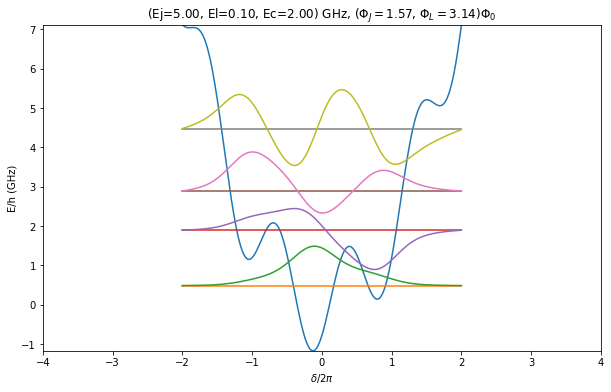

In [ ]:
def test_fluxonium():
    fluxonium = Fluxonium(Ej=5, El=0.1, Ec=2, phi=0.5*np.pi, phiL=np.pi, d=0.1, solve=True)
   #print(fluxonium.n_operator(4))
    fig= plt.figure(figsize=(10,6))
    fluxonium.plot(4)
    show()

print("Testing fluxonium solver")
test_fluxonium()

## References 
[1] Vladimir E. Manucharyan et al., "Fluxonium: Single Cooper-Pair Circuit Free of Charge Offsets", *Science* 326, 113 (2009). [10.1126/science.1175552](https://science.sciencemag.org/content/326/5949/113#:~:text=Abstract,in%20many%20solid%2Dstate%20systems.) <br>
[2] Long B. Nguyen, Yen-Hsiang Lin, Aaron Somoroff, Raymond Mencia, Nicholas Grabon, and Vladimir E. Manucharyan (2019), "High-Coherence Fluxonium Qubit", *Phys. Rev. X* 9, 041041. [10.1103/PhysRevX.9.041041](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.9.041041) <br>
[3] Koch, Jens et. al. (2009), "Charging Effects in the Inductively Shunted Josephson Junction", *Physical review letters*, 103. 217004. [10.1103/PhysRevLett.103.217004.](https://arxiv.org/pdf/0902.2980.pdf?origin=publication_detail&sa=U&ei=KJZNU-_oFIvAtAb6oYGACw&ved=0CCwQFjAD&usg=AFQjCNFv3g6-CH10blNt_lXbyBWS4sYMlA) <br> 
[4] Koolstra G., Schuster D., Yang G. (2017, November 16), *circuitqed*. <br> Retrieved from https://github.com/SchusterLab/slab/blob/master/circuitqed.py <br>